In [49]:
from scipy.integrate import solve_ivp
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

In [50]:
#k1 = 1         k2 = 2          phi_in = 1      phi_out = 2     v = 10          km = 1          klanda = 1      alpha*beta
#constants[0]   constants[1]    constants[2]    constants[3]    constants[4]    constants[5]    constants[6]    constants[7]  

#Valores estimados de las constantes MEAN
const_mean = [ 0.09350985, 0.58026128, 0.43635995, 0.54207802, -0.45358854, 0.6839959, 0.36064184, 0.65045037]
k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
print(k1)

0.09350985


With these values for the constants on the model we redo the previous procedure to compute A and P for different values of $n$ and $A_{out}$

In [51]:
def model1(t, variables, n, k1, k2, phi_in, phi_out, A_out, v, km, klanda, landa0):
    P, A = variables
    alpha = landa0/(1+klanda*A) #A initial o A a lo largo del tiempo(FUERA O DENTRO)
    dPdt = alpha*n*(1+k2)/((1+k1*A)**2*(1+k2*P)) - alpha*P
    dAdt = phi_in*A_out - phi_out*A - v*P*A/(km+P) - alpha*A
    return [dPdt, dAdt]


def model2(t, variables, n, k1, k2, phi_in, phi_out, A_out, v, km, klanda, landa0, alphaBeta):
    P, A = variables
    landa = landa0/(1+klanda*A) #A initial o A a lo largo del tiempo(FUERA O DENTRO)
    dPdt = alphaBeta*n/((1+k1*A)**2*(1+k2*P)) - landa*P
    dAdt = phi_in*A_out - phi_out*A - v*P*A/(km+P) - landa*A
    return [dPdt, dAdt]




In [52]:
def computeAPnaout(model,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist):
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    t_span = [0, tf]
    
    #P_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n
    #A_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n

    P_n_aout = []
    A_n_aout = []

    for i in range(0,len(Aout_values)):
        Pcurrent = []
        Acurrent = []
        for j in range(0,len(n_values)):
            sol = solve_ivp(model2, t_span, initial_conditions, args=(n_values[j],k1,k2, phi_in, phi_out, Aout_values[i], v, km, klanda, landa0, alphaBeta), t_eval=np.linspace(0, tf, equidist))
            #print(i,j)
            Pcurrent.append(sol.y[0])
            Acurrent.append(sol.y[1])
        P_n_aout.append(Pcurrent)
        A_n_aout.append(Acurrent)
    return(P_n_aout,A_n_aout)


def computeAPnaout_equilibrium(model,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist):
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    t_span = [0, tf]
    
    P_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n
    A_n_aout = np.zeros((len(Aout_values), len(n_values))) #x=Aout//y = n

    for i in range(0,len(Aout_values)):
        for j in range(0,len(n_values)):
            sol = solve_ivp(model2, t_span, initial_conditions, args=(n_values[j],k1,k2, phi_in, phi_out, Aout_values[i], v, km, klanda, landa0, alphaBeta), t_eval=np.linspace(0, tf, equidist))
            #print(i,j)
            P_n_aout[i,j] = sol.y[0][-1]
            A_n_aout[i,j] = sol.y[1][-1]
    return(P_n_aout,A_n_aout)



In [53]:
def Gfunction(A,landa0,klanda):
    return landa0/(1+klanda*A)

$$
    \frac{d}{dt}  B_1 =G(A_1,1)B_1-\delta\Big(B_1-2(1+\Delta)B_2 \Big),
$$
    
$$
    \frac{d}{dt}  B_n =G(A_n, n)B_n-\delta\Big(n(2+\Delta)B_n-(n-1)B_{n-1}-(n+1)(1+\Delta)B_{n+1} \Big),     (n=2, \dots, N-1)
$$
$$
    \frac{d}{dt}  B_N =G(A_N,N)B_N-\delta
    \Big(N(1+\Delta)B_N-(N-1)B_{N-1} \Big).
$$
The growth function $$G(A,n)=\frac{\lambda_0}{(1+k_\lambda
  A)}$$
  is decreased by the
internal antibiotic concentration. 

Where used constants are: $\delta=1e-2, \Delta=6.4$ and $k_c=0$

In [54]:
def model_Bn1(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables

    dB1dt = Gfunction(A_n_aout[Aout][0],landa0,klanda)*B1 - deltaMin*(B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9],landa0,klanda)*B10 - deltaMin*(10*(2+deltaMay)*B10+ - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]



def model_Bn2(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables
    #print(t)

    tt = int(t)
    if tt >= len(A_n_aout[Aout][0]):
        tt = -1

    #print(tt)

    dB1dt = Gfunction(A_n_aout[Aout][0][tt],landa0,klanda)*B1 - deltaMin*(B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1][tt],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2][tt],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3][tt],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4][tt],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5][tt],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6][tt],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7][tt],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8][tt],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9][tt],landa0,klanda)*B10 - deltaMin*(10*(1+deltaMay)*B10 - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]


def model_Bn3(t, variables, klanda,landa0,A_n_aout,deltaMin,deltaMay,Aout,equidist,tf):
    B1,B2,B3,B4,B5,B6,B7,B8,B9,B10 = variables
    #print(t)

    tt = int(t)
    if tt >= len(A_n_aout[Aout][0]):
        tt = -1

    #print(tt)

    dB1dt = Gfunction(A_n_aout[Aout][0][tt],landa0,klanda)*B1 - deltaMin*((2+deltaMay)*B1-2*(1+deltaMay)*B2)
    dB2dt = Gfunction(A_n_aout[Aout][1][tt],landa0,klanda)*B2 - deltaMin*(2*(2+deltaMay)*B2 - (1)*B1 - (3)*(1 + deltaMay)*B3 )
    dB3dt = Gfunction(A_n_aout[Aout][2][tt],landa0,klanda)*B3 - deltaMin*(3*(2+deltaMay)*B3 - (2)*B2 - (4)*(1 + deltaMay)*B4 )
    dB4dt = Gfunction(A_n_aout[Aout][3][tt],landa0,klanda)*B4 - deltaMin*(4*(2+deltaMay)*B4 - (3)*B3 - (5)*(1 + deltaMay)*B5 )
    dB5dt = Gfunction(A_n_aout[Aout][4][tt],landa0,klanda)*B5 - deltaMin*(5*(2+deltaMay)*B5 - (4)*B4 - (6)*(1 + deltaMay)*B6 )
    dB6dt = Gfunction(A_n_aout[Aout][5][tt],landa0,klanda)*B6 - deltaMin*(6*(2+deltaMay)*B6 - (5)*B5 - (7)*(1 + deltaMay)*B7 )
    dB7dt = Gfunction(A_n_aout[Aout][6][tt],landa0,klanda)*B7 - deltaMin*(7*(2+deltaMay)*B7 - (6)*B6 - (8)*(1 + deltaMay)*B8 )
    dB8dt = Gfunction(A_n_aout[Aout][7][tt],landa0,klanda)*B8 - deltaMin*(8*(2+deltaMay)*B8 - (7)*B7 - (9)*(1 + deltaMay)*B9 )
    dB9dt = Gfunction(A_n_aout[Aout][8][tt],landa0,klanda)*B9 - deltaMin*(9*(2+deltaMay)*B9 - (8)*B8 - (10)*(1 + deltaMay)*B10 )
    dB10dt = Gfunction(A_n_aout[Aout][9][tt],landa0,klanda)*B10 - deltaMin*(10*(2+deltaMay)*B10 - 9*B9)

    return [dB1dt,dB2dt,dB3dt,dB4dt,dB5dt,dB6dt,dB7dt,dB8dt,dB9dt,dB10dt]

In [55]:
def computeModelBN(tf,A_n_aout,Aout_values,const_mean,initial_conditions,equidist):
    #Constants
    k1 ,k2, phi_in ,phi_out , v , km , klanda , alphaBeta = const_mean
    deltaMin = 10**(-3)
    deltaMay = 6.4
    kc = 0
    landa0 = 0.43
    t_span = [0, tf]
    model_solution = []
    for i in range(0,len(Aout_values)):
        #print(i)
        sol = solve_ivp(model_Bn1,t_span,initial_conditions,args=(klanda,landa0,A_n_aout,deltaMin,deltaMay,i,equidist,tf),t_eval=np.linspace(0, tf, equidist))
        model_solution.append([sol.y[0],sol.y[1],sol.y[2],sol.y[3],sol.y[4],sol.y[5],sol.y[6],sol.y[7],sol.y[8],sol.y[9]])
    return(model_solution)


In [56]:
def computePromP(P_n_aout,Aout_values,n_values,model_solution,time):
    promP = np.zeros(len(Aout_values)) #x=Aout//y = n
    for i in range(0,len(Aout_values)):
        num = 0; den = 0
        for j in range(0,len(n_values)):
            num = num + P_n_aout[i][j]*model_solution[i][j][time]
            den = den + model_solution[i][j][time]
        promP[i] = num/den
    return(promP)


In [57]:
initial_conditions = [2, 0]  
n_values = np.linspace(1, 10, 10)
Aout_values = np.linspace(0, 50, 11)
landa0 = 0.43
tf = 100
equidist = 100
P,A = computeAPnaout_equilibrium(model2,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist)

print(len(A))
print(len(A[0]))
print(A[0][0])

11
10
0.0


In [58]:
initial_conditionsbn = [1] * 10
model234 = computeModelBN(tf,A,Aout_values,const_mean,initial_conditionsbn,equidist)
print(len(model234))
print(len(model234[0]))
print(len(model234[0][0]))

11
10
100


In [59]:
final_prom = []
print(len(final_prom))

P_n_aout = []
A_n_aout = []
initial_conditions = [2, 0] 
tf = 100
equidist = 100
landa0 = 0.43

P_n_aout,A_n_aout = computeAPnaout_equilibrium(model2,n_values,Aout_values,landa0,const_mean,tf,initial_conditions,equidist)

model_solution = []
initial_conditionsbn = [1,0,0,0,0,0,0,0,0,0]
model_solution = computeModelBN(tf,A_n_aout,Aout_values,const_mean,initial_conditionsbn,equidist)


0


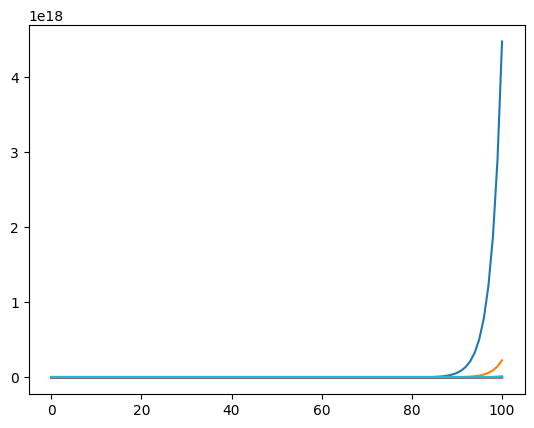

In [60]:
plt.figure()
for n in range (0,len(n_values)):
    a = 0
    plt.plot(np.linspace(0, tf, equidist),model_solution[a][n])

In [61]:
print(Aout_values)

[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]


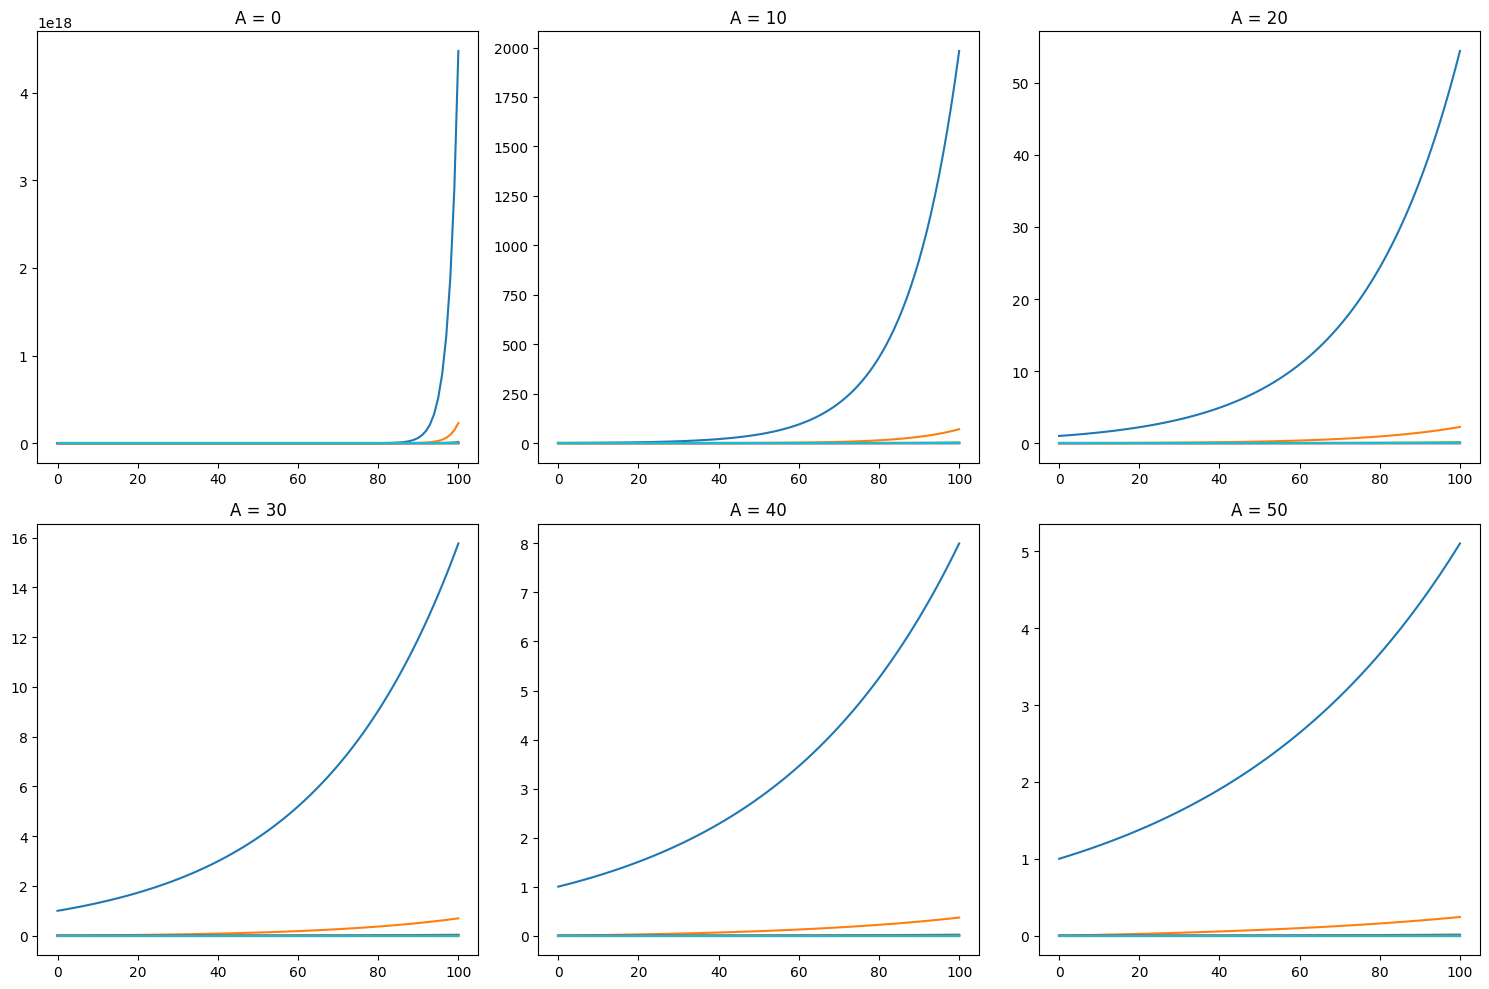

In [62]:
# Crear una figura y conjunto de subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

i = 0
for a in range (0,6,2):
    
    for n in range (0,len(n_values)):
        
        axs[0, i].plot(np.linspace(0, tf, equidist),model_solution[a][n])
        title = 'A = ' + str(a*5)
        axs[0, i].set_title(title)
    i = i+1


i = 0
for a in range (6,len(Aout_values),2):
    
    for n in range (0,len(n_values)):
        
        axs[1, i].plot(np.linspace(0, tf, equidist),model_solution[a][n])
        title = 'A = ' + str(a*5)
        axs[1, i].set_title(title)
    i = i+1

plt.tight_layout()
plt.show()


In [63]:
print(P_n_aout[0][0])
print(len(model_solution[0][0]))

0.9689964918942032
100


0
[0.96899649 1.17171736 1.08136674 0.96800019 0.87659877 0.80834578
 0.7615927  0.73434704 0.72419201 0.72812408 0.74296063]
1
[0.9696087  1.17241742 1.08197071 0.96852657 0.87707009 0.8087756
 0.76198841 0.73471258 0.72452943 0.72843483 0.74324609]
2
[0.97021238 1.17309691 1.08255982 0.96904148 0.87753192 0.80919722
 0.7623769  0.73507167 0.7248611  0.72874044 0.74352696]
3
[0.97080662 1.17375619 1.08313446 0.96954524 0.87798446 0.8096108
 0.7627583  0.73542446 0.72518713 0.729041   0.7438033 ]
4
[0.97139421 1.17439554 1.0836948  0.97003799 0.8784279  0.8100165
 0.76313274 0.73577104 0.72550762 0.7293366  0.7440752 ]
5
[0.97196986 1.17501611 1.08424117 0.97051996 0.87886241 0.81041447
 0.76350036 0.73611153 0.72582267 0.72962733 0.74434274]
6
[0.97254033 1.17561874 1.08477399 0.97099138 0.87928817 0.81080487
 0.76386128 0.73644605 0.72613238 0.72991327 0.74460599]
7
[0.97310414 1.17620361 1.08529373 0.9714525  0.87970537 0.81118783
 0.76421563 0.73677471 0.72643683 0.73019451 0.74486

Text(0.5, 1.0, 'Average P as a function of time for different $A_{out}$')

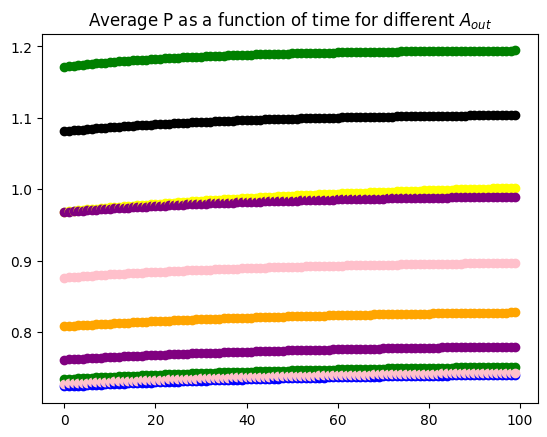

In [64]:
plt.figure()

for time in range (0,equidist):
    print(time)
    promP = []
    promP = computePromP(P_n_aout,Aout_values,n_values,model_solution,time)
    final_prom.append(promP)
    print(promP)

    plt.scatter(time, promP[0], color='yellow')
    plt.scatter(time, promP[1], color='green')
    plt.scatter(time, promP[2], color='black')
    plt.scatter(time, promP[3], color='purple')
    plt.scatter(time, promP[4], color='pink')
    plt.scatter(time, promP[5], color='orange')
    plt.scatter(time, promP[6], color='purple')
    plt.scatter(time, promP[7], color='green')
    plt.scatter(time, promP[8], color='blue')
    plt.scatter(time, promP[9], color='pink')
    
#plt.ylim(0,5)
plt.title('Average P as a function of time for different $A_{out}$')

In [65]:
import pandas as pd

df = pd.read_csv('C:/Users/raque/Documents/UNIVERSIDAD/UC3M/TFM/programación/gfp_data.csv')
Aout_experimental = df['Treatment'];GFP = df['GFP'];Hour_experimental = df['Hour']

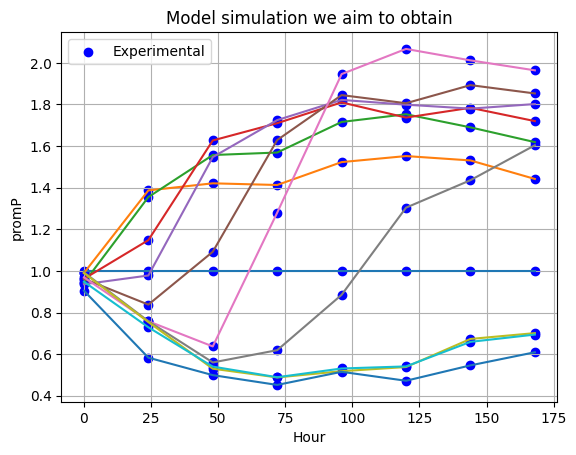

In [66]:
plt.figure()
for i in range (0,11):
    plt.plot(Hour_experimental[(8*i):8*(i+1)],GFP[(8*i):8*(i+1)])


plt.scatter(Hour_experimental, GFP, color='blue', label='Experimental')

plt.xlabel('Hour')
plt.ylabel('promP')
plt.title('Model simulation we aim to obtain')
plt.grid(True)
plt.legend()